# Step 1 Target analysis of TA of ideal WL-PSI

### Inspect data

In [1]:
from cycler import cycler
from glotaran.io import load_parameters, save_result
from glotaran.optimization.optimize import optimize
from glotaran.project.scheme import Scheme
from pyglotaran_extras.plotting.plot_overview import plot_overview
from pyglotaran_extras.plotting.plot_traces import (
    plot_fitted_traces,
    select_plot_wavelengths,
)
from pyglotaran_extras.inspect import show_a_matrixes


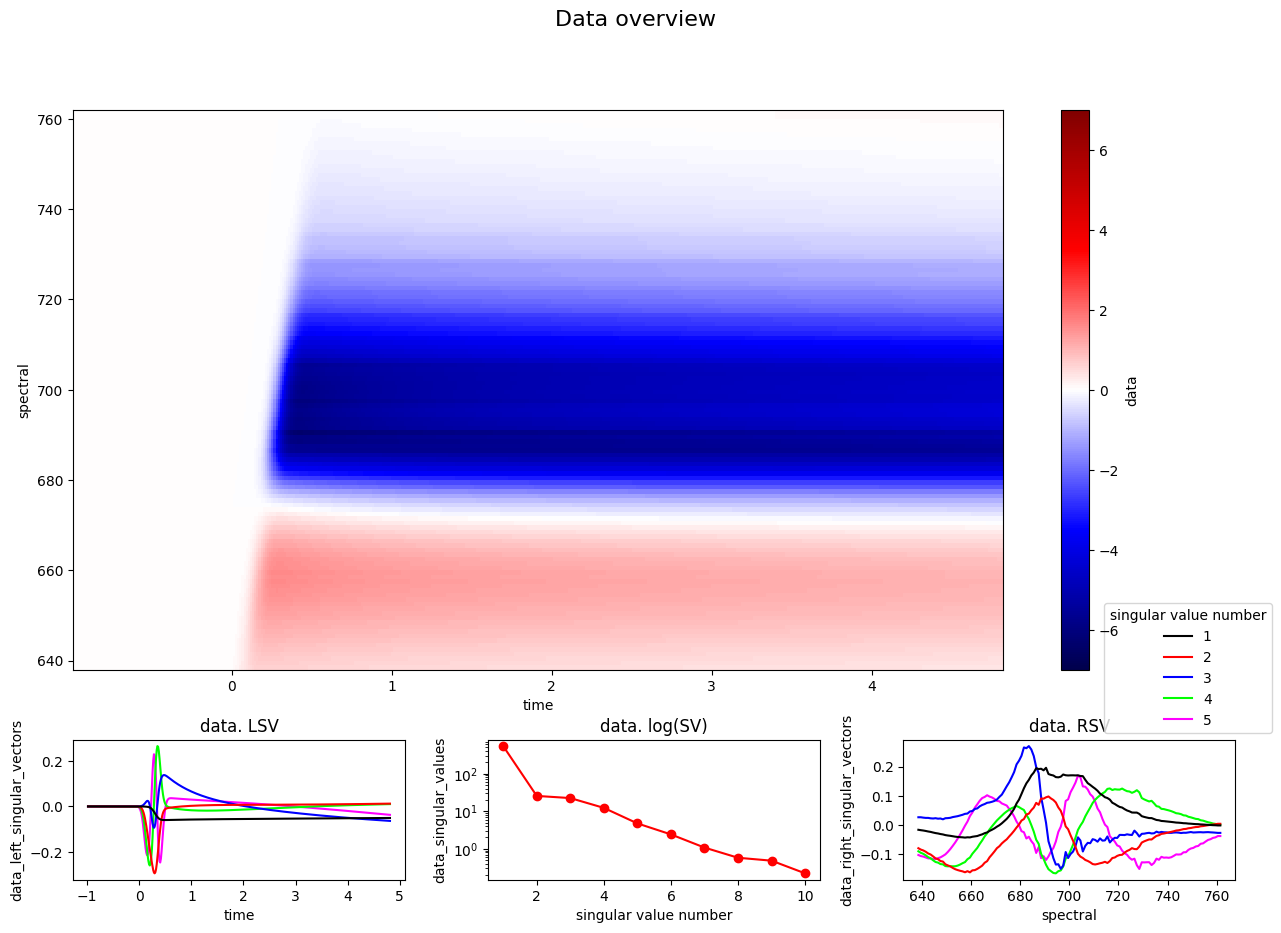

In [2]:
from pyglotaran_extras import plot_data_overview

DATA_PATH3 = "data/synWTred_idealc.ascii"
DATA_PATH4 = "data/synWTred_ideald.ascii"
fig, axes = plot_data_overview(
    DATA_PATH3,
    nr_of_data_svd_vectors=5,
    linlog=False,
    cmap="seismic",
    vmin=-7,
    vmax=7,
    use_svd_number=True,
)


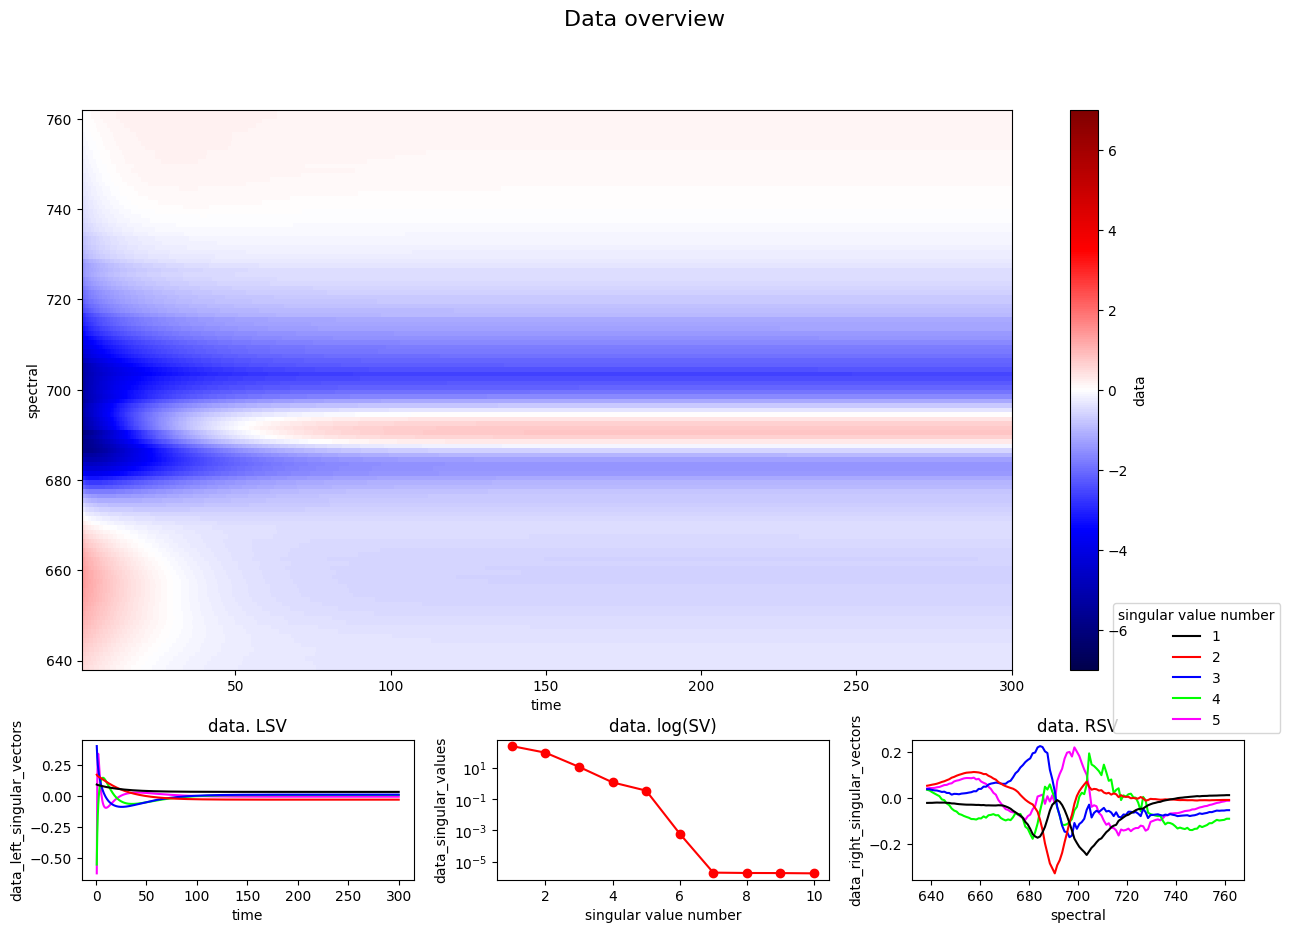

In [3]:
fig, axes = plot_data_overview(
    DATA_PATH4,
    nr_of_data_svd_vectors=5,
    linlog=False,
    linthresh=10,
    cmap="seismic",
    vmin=-7,
    vmax=7,
    use_svd_number=True,
)


## Target Analysis

### Used model and parameters

In [4]:
target_model_path = "models/ideal_target_model_PSI_TA.yml"


In [5]:
target_parameters_path = "models/ideal_target_parameters_PSI_TA.csv"
optimized_parameters = load_parameters(target_parameters_path)


#### Model file

In [6]:
# Uncomment the following 2 lines to display the target model file in the notebook
from glotaran.utils.ipython import display_file
display_file(target_model_path, syntax="yaml")

# Alternatively (recommended), open the file in a text editor to see the model definition


```yaml
# default_megacomplex: decay
dataset_groups:
  default:
    residual_function: variable_projection
    link_clp: True

dataset:
  # TA datasets
  # 670TR1:
  #   # megacomplex: [complex670]
  #   megacomplex: [complex670, doas, artifact670]
  #   # megacomplex_scale: [scalem.1,scalem.freeChl]
  #   initial_concentration: input670
  #   irf: irf1
  #   scale: scale.670
  # 670TR2:
  #   # megacomplex: [complex670TR2]
  #   megacomplex: [complex670]
  #   # megacomplex_scale: [scalem.1,scalem.freeChl]
  #   initial_concentration: input670
  #   irf: irf1
  #   scale: scale.670TR2
  700TR1:
    megacomplex: [complex700]
    # megacomplex: [complex700, artifact700]
    # megacomplex_scale: [scalem.1]
    initial_concentration: input700
    irf: irf2
    scale: scale.700
  700TR2:
    # megacomplex: [complex700TR2]
    megacomplex: [complex700]
    # megacomplex_scale: [scalem.1]
    initial_concentration: input700
    irf: irf2
    scale: scale.700TR2

megacomplex:
  # unique for TA
  # complex670:
  #   type: decay
  #   k_matrix: [kmBulkAnt1, kmBulkWL, kmRC, kmRP670, kfreeChl]
  complex700:
    type: decay
    k_matrix: [kmWL]

# how can i now express that the first 20 lines
# are common for complexes 1-5, and the next 11 lines
# are common for complexes 1-4? how can i specify in chunks?
# note that earlier definition will override later definition
k_matrix:
  # xrates correction for different numbers of Bulk Chl a pigments (78 vs 70)
  # yrates correction for different temperatures (6 vs 20 C)
  # kfreeChl:
  #   matrix:
  #     (freeChl, freeChl): rates.kF
  kmWL:
    matrix:
      (Bulk, Red): rates.ToBulkFromRed
      (Red, Bulk): rates.ToRedFromBulk
      (Red, Red): rates.kF
      (Bulk, Bulk): rates.kF
      (RC, RC): rates.kF
      (RC, RP1): rates.ToRCFromRP1
      (RP1, RC): rates.ToRP1FromRC
      (Bulk, RC): rates.ToBulkFromRC
      (RC, Bulk): rates.ToRCFromBulk
      (RP2, RP1): rates.ToRP2FromRP1
      (RP2, RP2): rates.ToRP2FromRP2

initial_concentration:
  # unique for TA
  # input670:
  #   compartments: [Ant1, Bulk, Red, RC, RP1, RP2, freeChl]
  #   parameters:
  #     [
  #       input670.Ant1,
  #       input670.Bulk,
  #       input670.Red,
  #       input670.RC,
  #       input670.0,
  #       input670.0,
  #       input670.freeChl,
  #     ]
  input700:
    compartments: [Bulk, Red, RC, RP1, RP2]
    parameters:
      [
        input700.Bulk,
        input700.Red,
        input700.RC,
        input700.0,
        input700.0,
      ]

# it is implicitly normalized, i.e. divided by sum of irfscale parameters
irf:
  # irf1:
  #   type: spectral-gaussian
  #   center: irf.center1
  #   width: irf.width1
  #   dispersion_center: irf.dispcenter
  #   center_dispersion_coefficients: [irf.disp1]
  #   model_dispersion_with_wavenumber: true
  irf2:
    type: spectral-gaussian
    center: irf.center2
    width: irf.width2
    dispersion_center: irf.dispcenter
    center_dispersion_coefficients: [irf.disp1]
    model_dispersion_with_wavenumber: true

# weights:
#   # unique for TA
#   - datasets: [RedSADS]
#     # if omitted the weight applies everywhere
#     global_interval: [100, 1000]
#     # this would be time
#     # model_interval: [100, 1000]
#     value: 6.e-5
#     # value: 6.e-3
#   # - datasets: [Red2SADS]
#   #   global_interval: [100, 1000]
#   #   value: 6.e-3
#   - datasets: [RCSADS]
#     global_interval: [100, 1000]
#     # value: 6.e-3
#     value: 6.e-5
#   - datasets: [RP1SADS]
#     global_interval: [100, 1000]
#     # value: 6.e-3
#     value: 6.e-6

```

#### Parameters file

In [7]:
# Uncomment the next line and run the cell to print the starting values of the analysis
# These starting values have already been optimized, hence the name optimized_parameters

# optimized_parameters


### Create scheme and optimize it

In [8]:
target_scheme = Scheme(
    model=target_model_path,  # type: ignore
    parameters=optimized_parameters,
    maximum_number_function_evaluations=7,
    clp_link_tolerance=0.1,
    data={
        # TA data
        "700TR1": DATA_PATH3,
        "700TR2": DATA_PATH4,
    },  # type: ignore
)
target_scheme.validate()


Your model is valid.

Final Cost
-  6         7.7517e-05

In [9]:
target_result = optimize(target_scheme, raise_exception=True)


   Iteration     Total nfev        Cost      Cost reduction    Step norm     Optimality   
       0              1         3.1690e+01                                    3.80e+03    
       1              2         4.2094e-01      3.13e+01       2.21e-01       1.32e+03    
       2              3         5.2364e-02      3.69e-01       4.44e-02       8.86e+02    
       3              4         7.9514e-05      5.23e-02       2.46e-03       8.41e+00    
       4              5         7.7517e-05      2.00e-06       1.69e-05       9.48e-04    
       5              6         7.7517e-05      7.47e-14       3.78e-08       1.46e-06    
`ftol` termination condition is satisfied.
Function evaluations 6, initial cost 3.1690e+01, final cost 7.7517e-05, first-order optimality 1.46e-06.


To save the results of the optimization we can use the `save_result` command.

Because it saves *everything* it consumes about 50MB of disk space per save.

In [10]:
save_result(
    result=target_result,
    result_path="results/ideal/result.yaml",
    allow_overwrite=True,
)


['results/ideal/result.md',
 'results/ideal/initial_parameters.csv',
 'results/ideal/optimized_parameters.csv',
 'results/ideal/parameter_history.csv',
 'results/ideal/optimization_history.csv',
 'results/ideal/700TR1.nc',
 'results/ideal/700TR2.nc',
 'results/ideal/model.yml',
 'results/ideal/scheme.yml',
 'results/ideal/result.yaml']

### Results and parameters

In [11]:
# Just call the result to get the optimization result summary.
target_result
# For easier copy-and-paste try:
# print(target_result)


| Optimization Result                       |          |
|-------------------------------------------|----------|
| Number of residual evaluation             | 6        |
| Number of residuals                       | 128340   |
| Number of free parameters                 | 9        |
| Number of conditionally linear parameters | 620      |
| Degrees of freedom                        | 127711   |
| Chi Square                                | 1.55e-04 |
| Reduced Chi Square                        | 1.21e-09 |
| Root Mean Square Error (RMSE)             | 3.48e-05 |

| RMSE (per dataset)   |   weighted |   unweighted |
|----------------------|------------|--------------|
| 1.700TR1:            |   5.01e-05 |     5.01e-05 |
| 2.700TR2:            |   1.61e-05 |     1.61e-05 |

<br><details>

### Model

#### Dataset Groups

- **default**
  - _Label_: default
  - _Residual Function_: variable_projection
  - _Link Clp_: True


#### K Matrix

- **kmWL**
  - _Label_: kmWL
  - _Matrix_: {('Bulk', 'Red'): 'rates.ToBulkFromRed(2.00e-01=_rates.ToRedFromBulk(1.17e-01±3.61e-06, t-value: 32338)_*exp(_dG.Red(5.41e-01, fixed)_))', ('Red', 'Bulk'): 'rates.ToRedFromBulk(1.17e-01±3.61e-06, t-value: 32338, initial: 1.18e-01)', ('Red', 'Red'): 'rates.kF(7.38e-04, fixed)', ('Bulk', 'Bulk'): 'rates.kF(7.38e-04, fixed)', ('RC', 'RC'): 'rates.kF(7.38e-04, fixed)', ('RC', 'RP1'): 'rates.ToRCFromRP1(5.49e-03±4.44e-07, t-value: 12347, initial: 5.38e-03)', ('RP1', 'RC'): 'rates.ToRP1FromRC(9.00e-01, fixed)', ('Bulk', 'RC'): 'rates.ToBulkFromRC(8.57e-01=_rates.ToRCFromBulk(1.91e-01±3.84e-06, t-value: 49873)_*exp(_dG.RC(1.50e+00, fixed)_))', ('RC', 'Bulk'): 'rates.ToRCFromBulk(1.91e-01±3.84e-06, t-value: 49873, initial: 1.91e-01)', ('RP2', 'RP1'): 'rates.ToRP2FromRP1(5.80e-02±8.01e-07, t-value: 72416, initial: 5.85e-02)', ('RP2', 'RP2'): 'rates.ToRP2FromRP2(3.00e-05±2.66e-09, t-value: 11317, initial: 1.00e-05)'}


#### Megacomplex

- **complex700**
  - _Label_: complex700
  - _Dimension_: time
  - _Type_: decay
  - _K Matrix_: ['kmWL']


#### Initial Concentration

- **input700**
  - _Label_: input700
  - _Compartments_: ['Bulk', 'Red', 'RC', 'RP1', 'RP2']
  - _Parameters_: ['input700.Bulk(3.40e-01, fixed)', 'input700.Red(4.60e-01=1-_input700.Bulk(3.40e-01, fixed)_-_input700.RC(2.00e-01, fixed)_)', 'input700.RC(2.00e-01, fixed)', 'input700.0(0.00e+00, fixed)', 'input700.0(0.00e+00, fixed)']
  - _Exclude From Normalize_: []


#### Irf

- **irf2**
  - _Label_: irf2
  - _Normalize_: True
  - _Backsweep_: False
  - _Dispersion Center_: irf.dispcenter(7.00e+02, fixed)
  - _Center Dispersion Coefficients_: ['irf.disp1(-1.70e+00±1.98e-06, t-value: -861161, initial: -1.91e+00)']
  - _Width Dispersion Coefficients_: []
  - _Model Dispersion With Wavenumber_: True
  - _Type_: spectral-gaussian
  - _Center_: irf.center2(3.12e-01±6.24e-08, t-value: 5010588, initial: 3.03e-01)
  - _Width_: irf.width2(5.05e-02±7.96e-08, t-value: 634735, initial: 5.59e-02)


#### Dataset

- **700TR1**
  - _Label_: 700TR1
  - _Group_: default
  - _Force Index Dependent_: False
  - _Megacomplex_: ['complex700']
  - _Scale_: scale.700(1.00e+00, fixed)
  - _Initial Concentration_: input700
  - _Irf_: irf2

- **700TR2**
  - _Label_: 700TR2
  - _Group_: default
  - _Force Index Dependent_: False
  - _Megacomplex_: ['complex700']
  - _Scale_: scale.700TR2(1.01e+00±3.22e-07, t-value: 3136578, initial: 1.00e+00)
  - _Initial Concentration_: input700
  - _Irf_: irf2



</section></section></details><section><section>

In [12]:
# Access the result's `optimized_parameters` to print a markdown table of the optimized parameters:
target_result.optimized_parameters


  * __dG__:

    | _Label_   |   _Value_ |   _Standard Error_ | _t-value_   |    _Minimum_ |   _Maximum_ | _Vary_   | _Non-Negative_   | _Expression_   |
    |-----------|-----------|--------------------|-------------|--------------|-------------|----------|------------------|----------------|
    | Red       | 5.410e-01 |                nan |  nan        | -inf         |         inf | False    | False            | `None`         |
    | RC        | 1.500e+00 |                nan |  nan        |    0.000e+00 |         inf | False    | False            | `None`         |

  * __input700__:

    | _Label_   |   _Value_ |   _Standard Error_ | _t-value_   |   _Minimum_ |   _Maximum_ | _Vary_   | _Non-Negative_   | _Expression_                    |
    |-----------|-----------|--------------------|-------------|-------------|-------------|----------|------------------|---------------------------------|
    | Bulk      | 3.400e-01 |                nan |  nan        |        -inf |         inf | False    | False            | `None`                          |
    | Red       | 4.600e-01 |                nan |  nan        |        -inf |         inf | False    | False            | `1-$input700.Bulk-$input700.RC` |
    | RC        | 2.000e-01 |                nan |  nan        |        -inf |         inf | False    | False            | `None`                          |
    | 0         | 0.000e+00 |                nan |  nan        |        -inf |         inf | False    | False            | `None`                          |

  * __irf__:

    | _Label_    |    _Value_ |   _Standard Error_ | _t-value_   |   _Minimum_ |   _Maximum_ | _Vary_   | _Non-Negative_   | _Expression_   |
    |------------|------------|--------------------|-------------|-------------|-------------|----------|------------------|----------------|
    | center2    |  3.124e-01 |          6.235e-08 |  5010588    |        -inf |         inf | True     | False            | `None`         |
    | width2     |  5.051e-02 |          7.958e-08 |  634735     |        -inf |         inf | True     | False            | `None`         |
    | disp1      | -1.703e+00 |          1.978e-06 |  -861161    |        -inf |         inf | True     | False            | `None`         |
    | dispcenter |  7.000e+02 |        nan         |  nan        |        -inf |         inf | False    | False            | `None`         |

  * __rates__:

    | _Label_       |   _Value_ |   _Standard Error_ | _t-value_   |   _Minimum_ |   _Maximum_ | _Vary_   | _Non-Negative_   | _Expression_                        |
    |---------------|-----------|--------------------|-------------|-------------|-------------|----------|------------------|-------------------------------------|
    | kF            | 7.380e-04 |        nan         |  nan        |        -inf |         inf | False    | False            | `None`                              |
    | ToBulkFromRed | 2.003e-01 |        nan         |  nan        |        -inf |         inf | False    | False            | `$rates.ToRedFromBulk*exp($dG.Red)` |
    | ToRedFromBulk | 1.166e-01 |          3.605e-06 |  32338      |        -inf |         inf | True     | False            | `None`                              |
    | ToBulkFromRC  | 8.574e-01 |        nan         |  nan        |        -inf |         inf | False    | False            | `$rates.ToRCFromBulk*exp($dG.RC)`   |
    | ToRCFromBulk  | 1.913e-01 |          3.836e-06 |  49873      |        -inf |         inf | True     | False            | `None`                              |
    | ToRCFromRP1   | 5.487e-03 |          4.444e-07 |  12347      |        -inf |         inf | True     | False            | `None`                              |
    | ToRP1FromRC   | 9.000e-01 |        nan         |  nan        |        -inf |         inf | False    | False            | `None`                              |
    | ToRP2FromRP1  | 5.801e-02 |          8.010e-07 |  72416      |        -inf |         inf | True     | False            | `None`                              |
    | ToRP2FromRP2  | 3.005e-05 |          2.655e-09 |  11317      |        -inf |         inf | True     | False            | `None`                              |

  * __scale__:

    | _Label_   |   _Value_ |   _Standard Error_ | _t-value_   |   _Minimum_ |   _Maximum_ | _Vary_   | _Non-Negative_   | _Expression_   |
    |-----------|-----------|--------------------|-------------|-------------|-------------|----------|------------------|----------------|
    | 700       | 1.000e+00 |        nan         |  nan        |        -inf |         inf | False    | False            | `None`         |
    | 700TR2    | 1.010e+00 |          3.221e-07 |  3136578    |        -inf |         inf | True     | False            | `None`         |



## Result plots

<sub>Note: The color scheme of the plots in this notebook may not match published figures.</sub>

## Fit quality

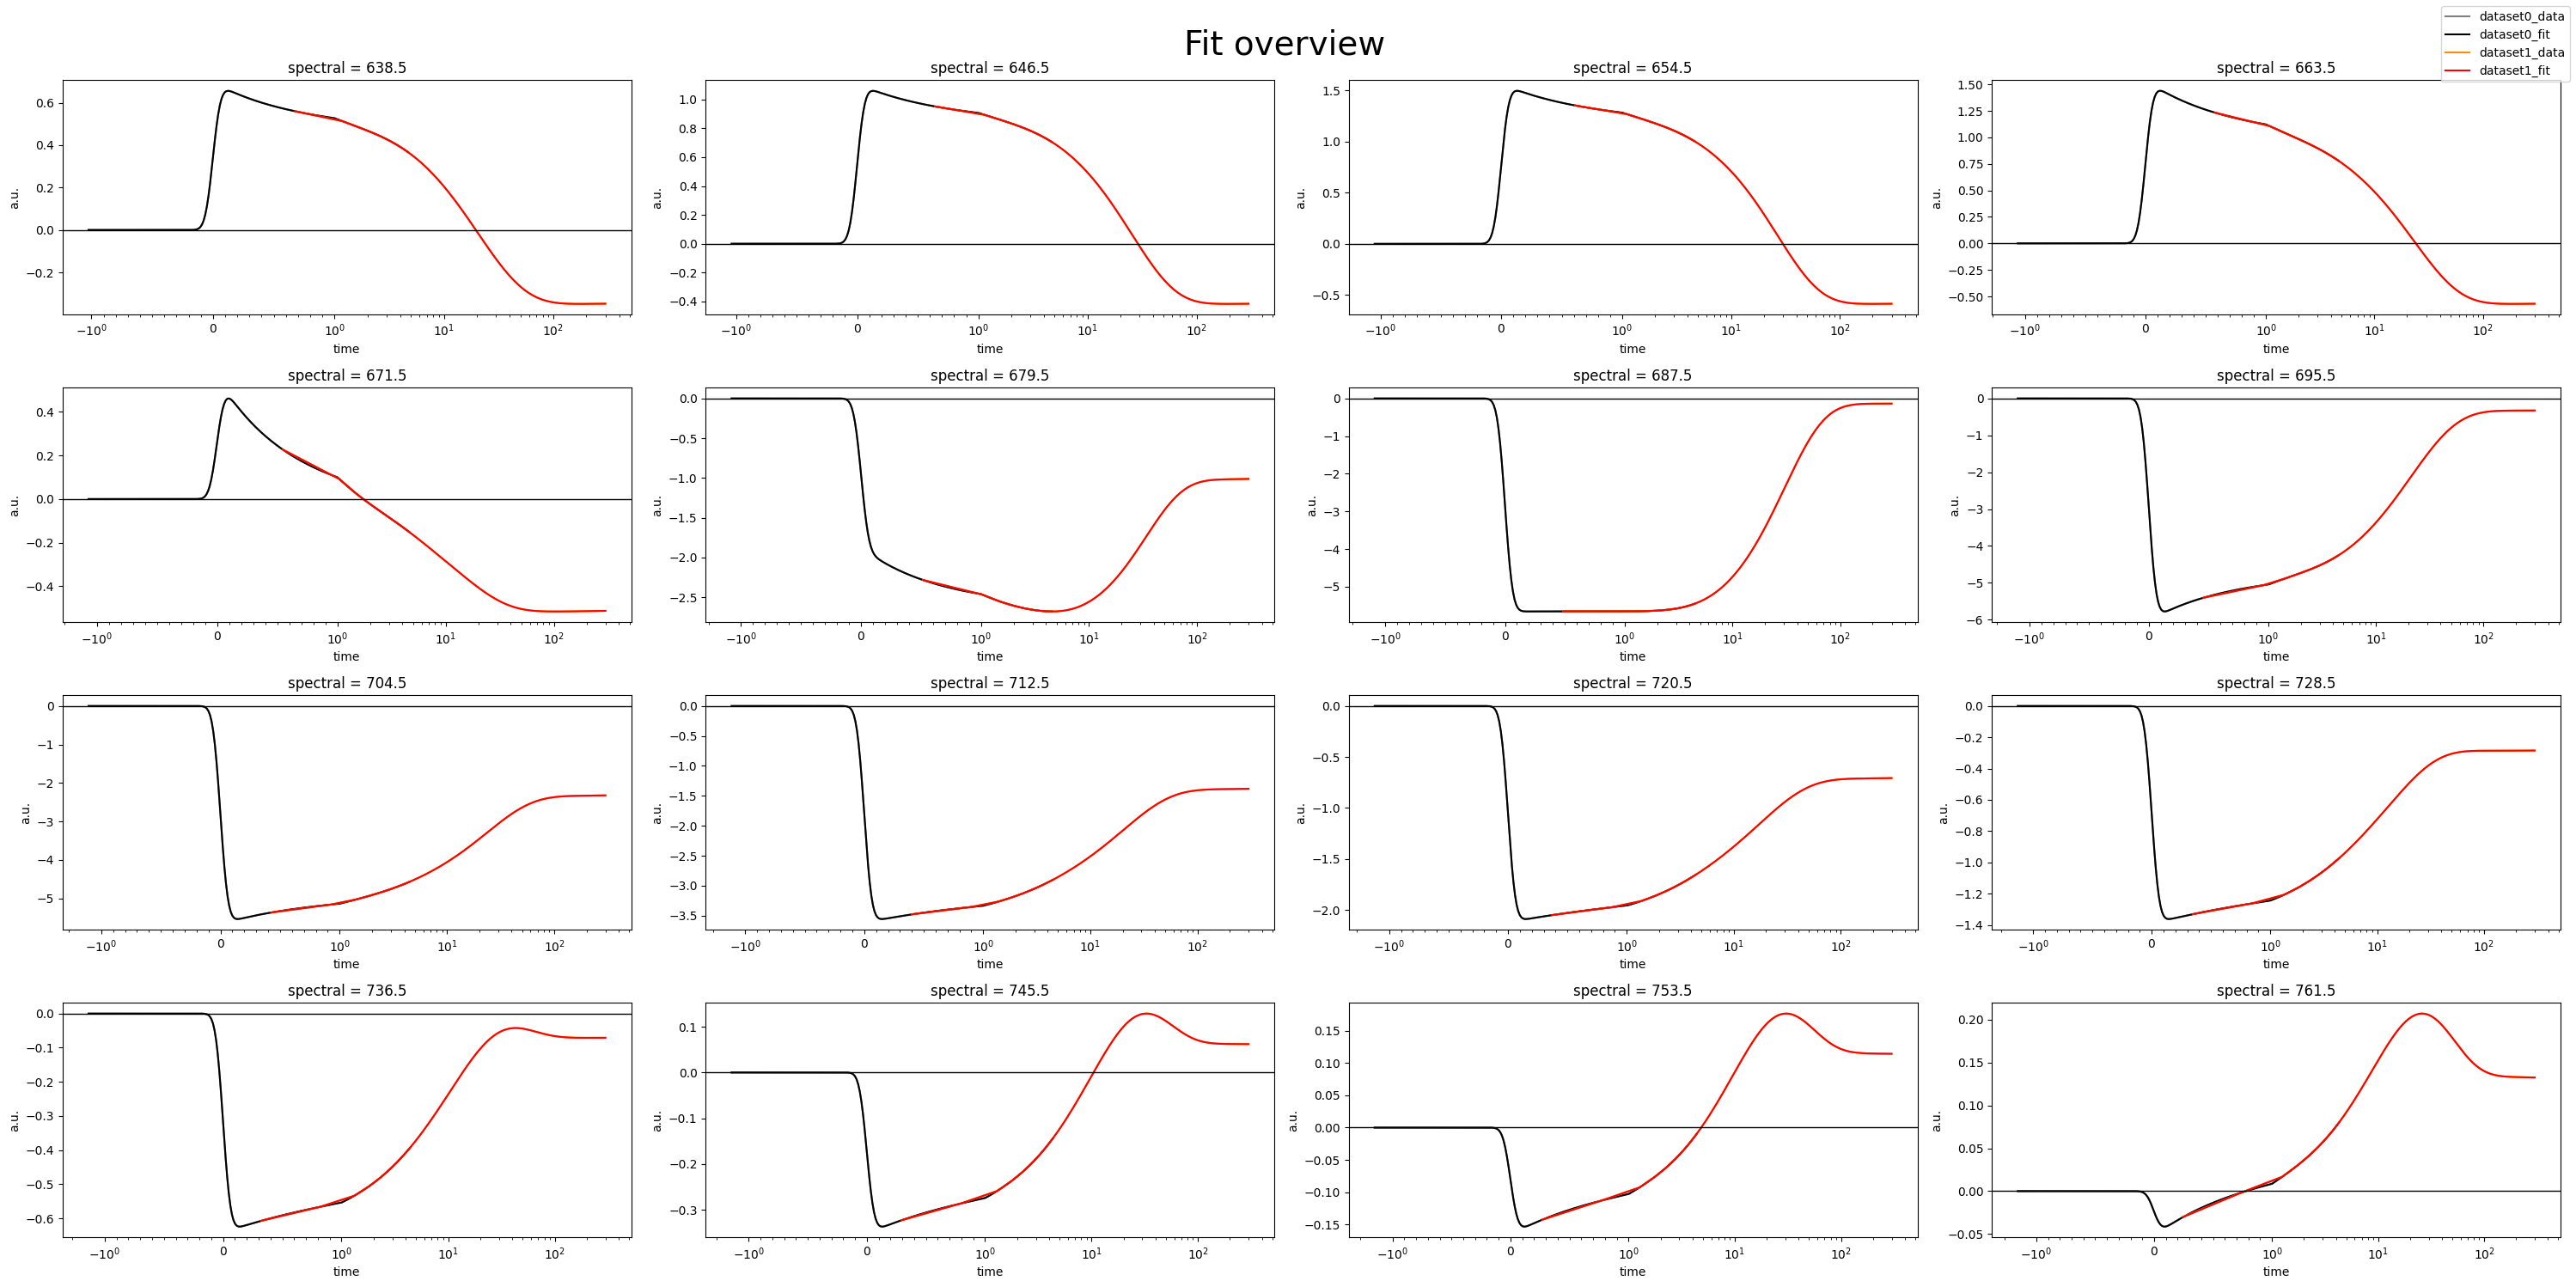

In [13]:
target_result_TA = (
    target_result.data["700TR1"],
    target_result.data["700TR2"],
)
wavelengths = select_plot_wavelengths(target_result_TA, equidistant_wavelengths=True)
plot_fitted_traces(target_result_TA, wavelengths, linlog=True, linthresh=1);


The above command `plot_fitted_traces` is used to plot a selection of traces for a set of wavelengths (autogenerated using the `select_plot_wavelengths` function).

## Overview 700 exc

Note that the final rms error is 3.5E-5, which is almost a million times smaller than the largest signal, a signal to noise ratio that is of course experimentally impossible. This residual matrix still shows some structure in the overview plots below.

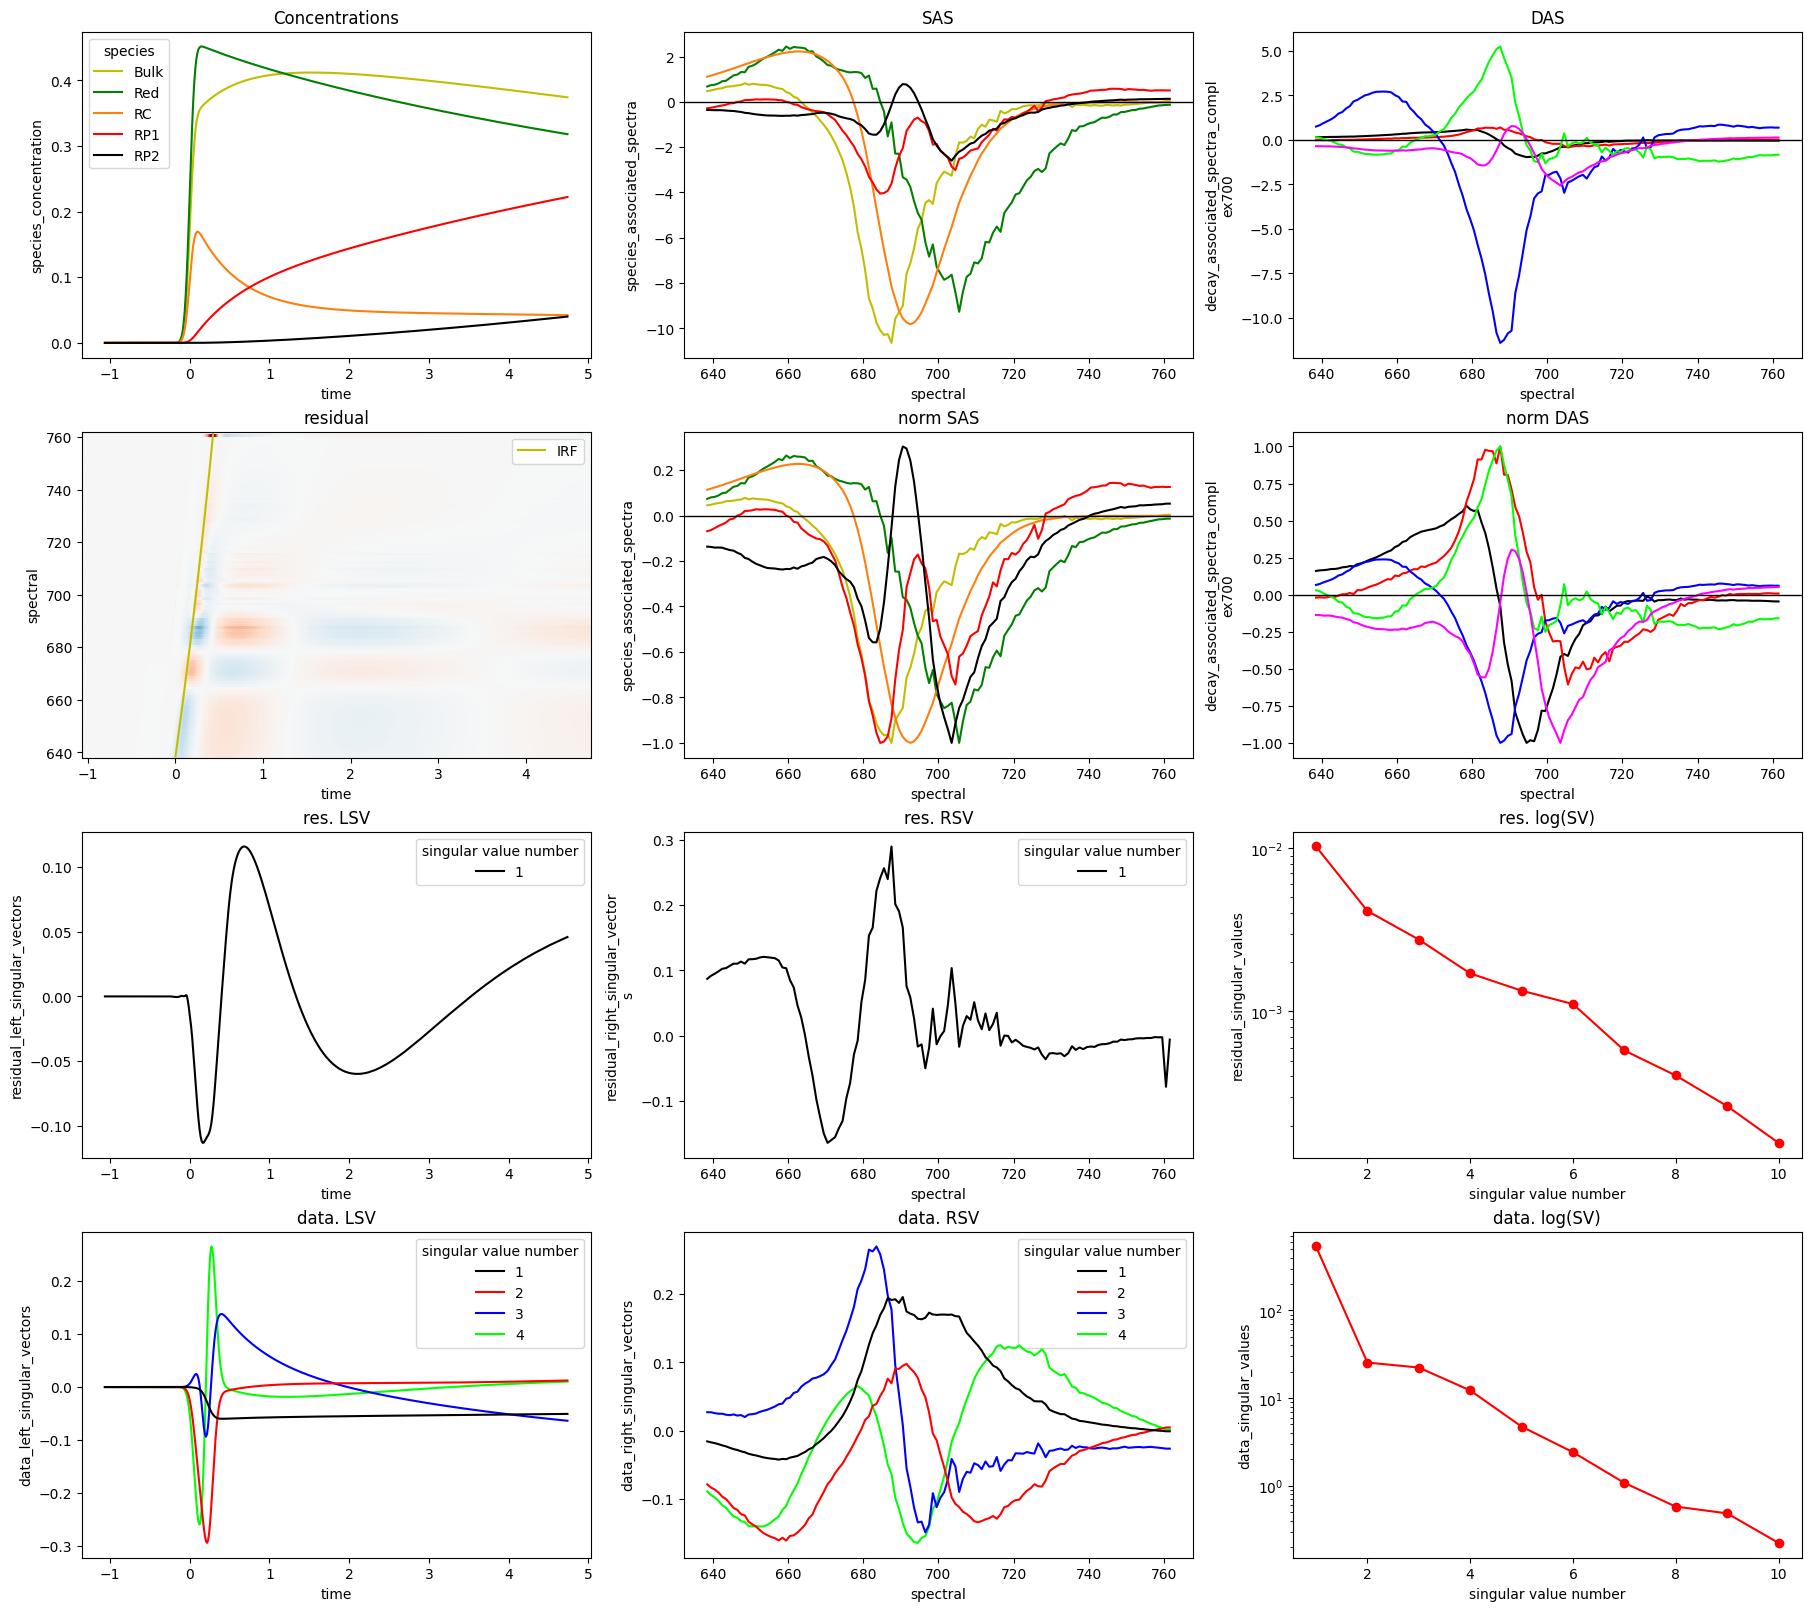

In [14]:
from pyglotaran_extras.plotting.style import PlotStyle

fig_700tr1 = plot_overview(
    target_result.data["700TR1"],
    nr_of_data_svd_vectors=4,
    nr_of_residual_svd_vectors=1,
    linlog=False,
    linthresh=1,
    cycler=cycler(
        color=["y", "g", "tab:orange", "r", "k", "c", "b", "m", "tab:purple"]
    ),
    use_svd_number=True,
    das_cycler=PlotStyle().cycler,
    svd_cycler=PlotStyle().cycler,
)


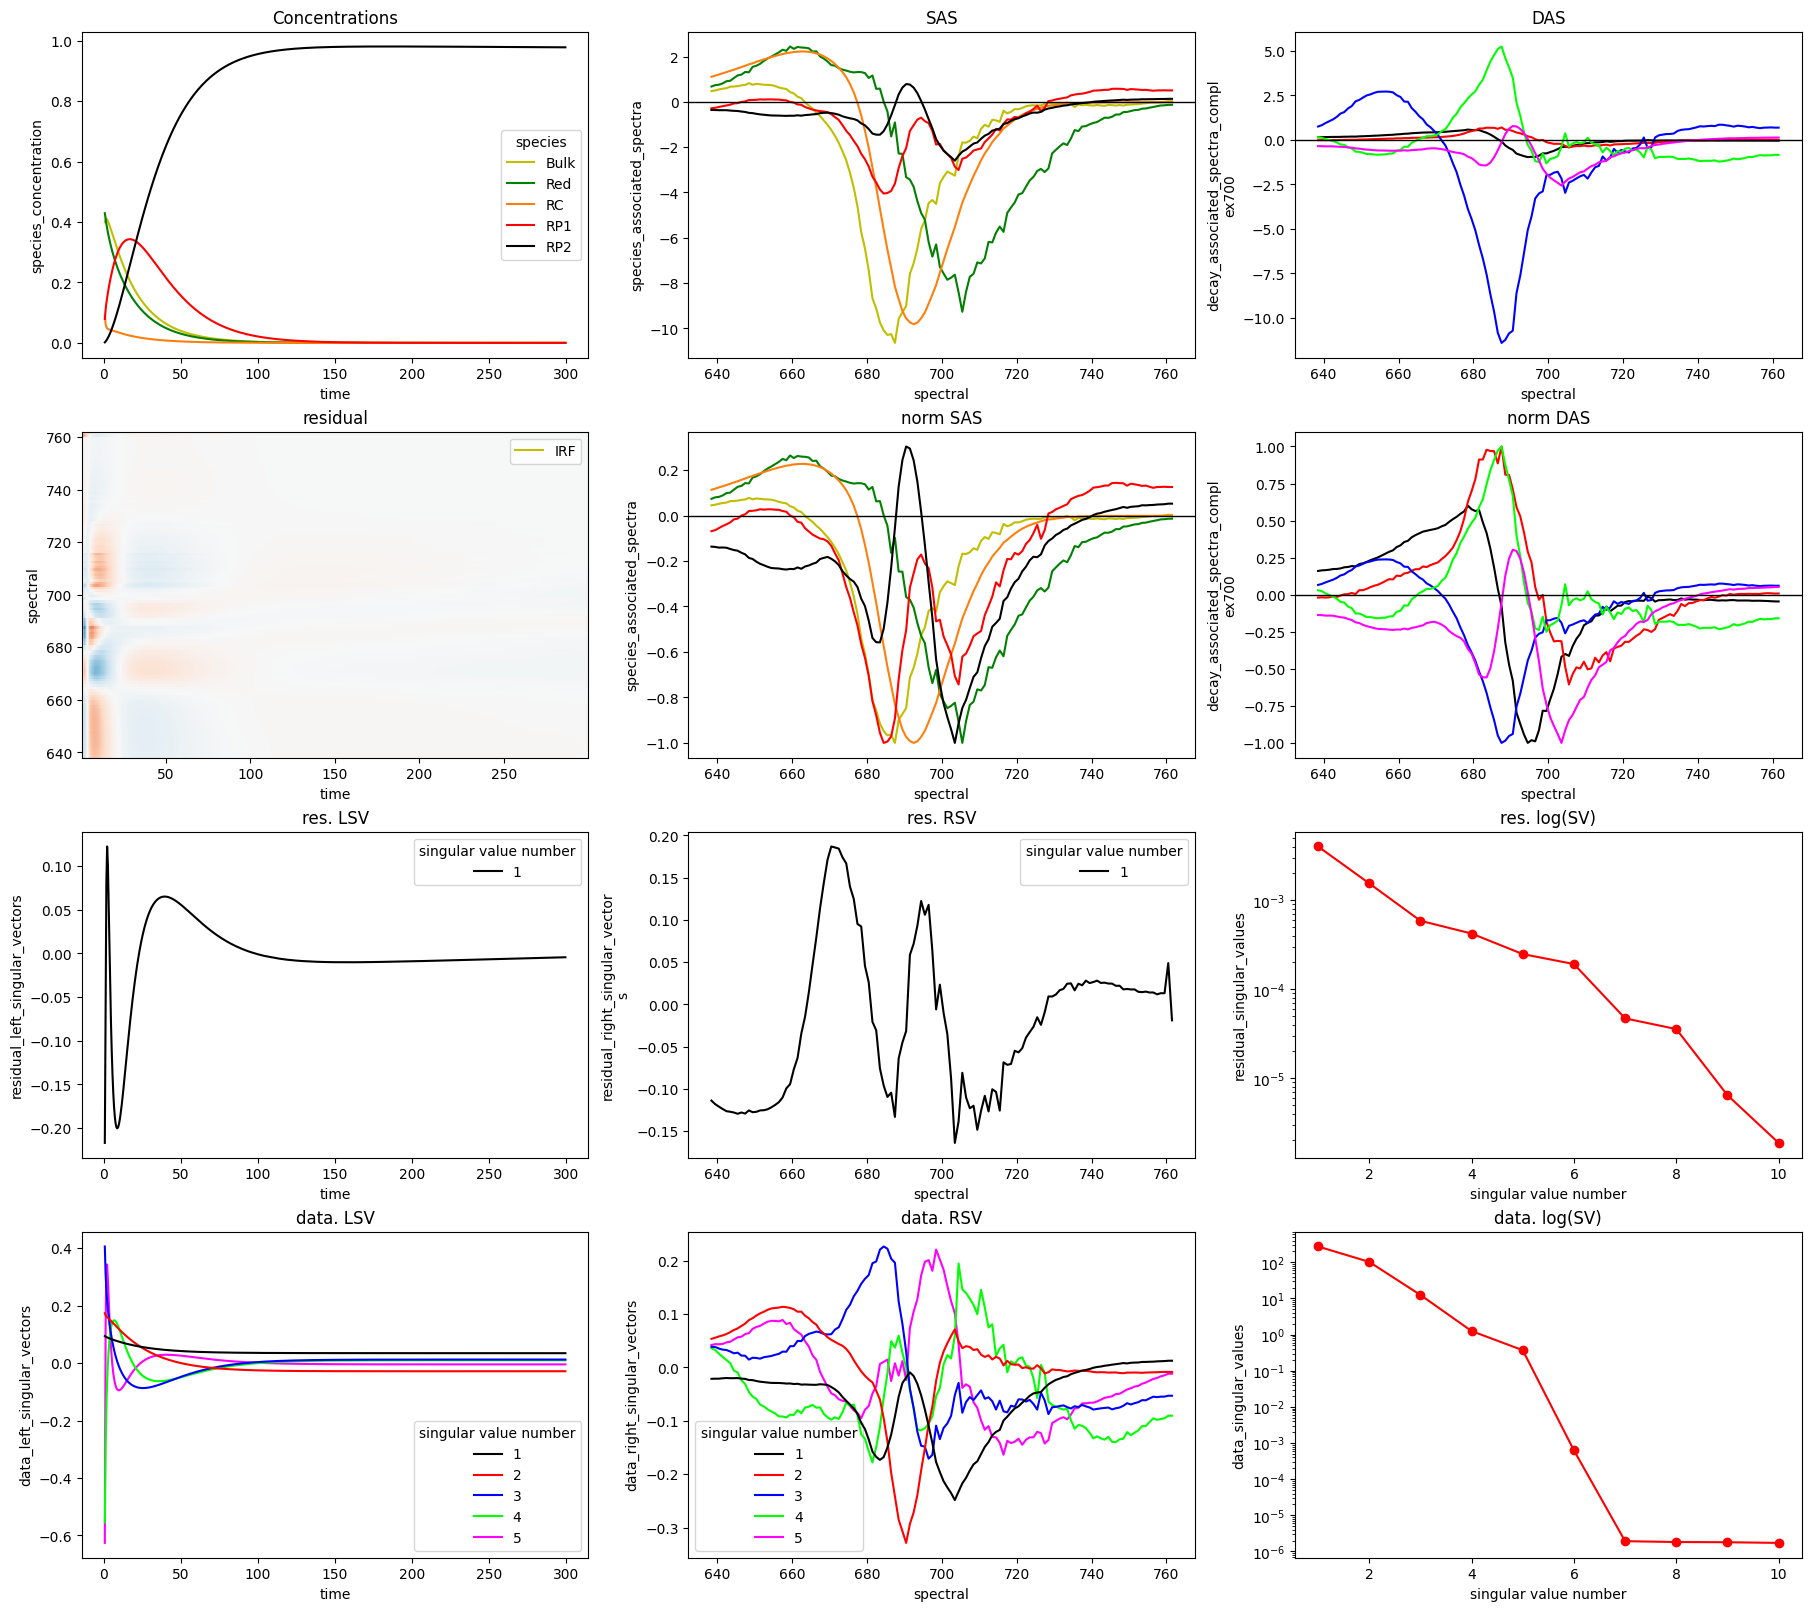

In [15]:
fig_700tr2 = plot_overview(
    target_result.data["700TR2"],
    nr_of_data_svd_vectors=5,
    nr_of_residual_svd_vectors=1,
    linlog=False,
    linthresh=1,
    cycler=cycler(
        color=["y", "g", "tab:orange", "r", "k", "c", "b", "m", "tab:purple"]
    ),
    use_svd_number=True,
    das_cycler=PlotStyle().cycler,
    svd_cycler=PlotStyle().cycler,
)


## Plot result for interpretation


Text(-0.05, 1.02, 'C')

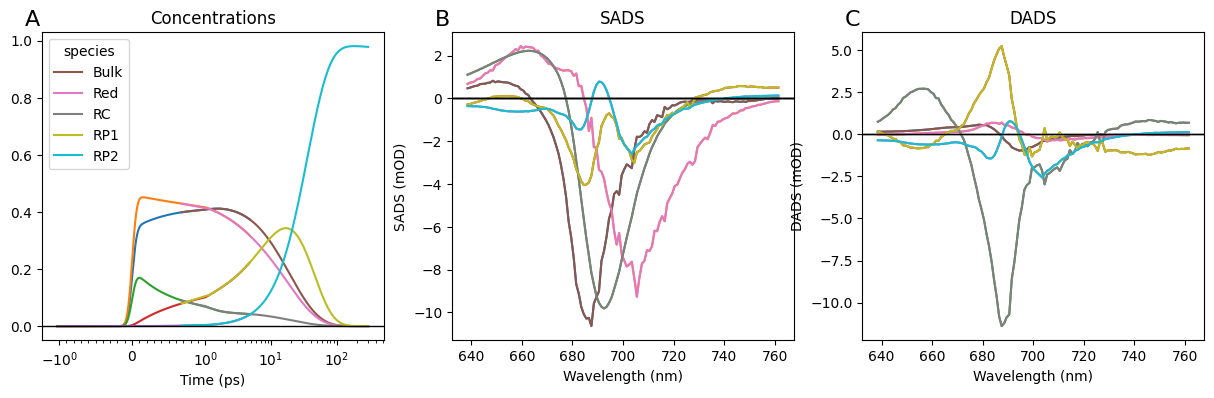

In [16]:
from custom_plotting import plot_concentration_and_spectra

fig, axes = plot_concentration_and_spectra(
    [target_result.data["700TR1"], target_result.data["700TR2"]]
)
axes[0].set_xlabel("Time (ps)")
axes[0].set_ylabel("")
axes[0].axhline(0, color="k", linewidth=1)
axes[1].set_xlabel("Wavelength (nm)")
axes[1].set_ylabel("SADS (mOD)")
axes[1].set_title("SADS")
axes[2].set_xlabel("Wavelength (nm)")
axes[2].set_ylabel("DADS (mOD)")
axes[2].set_title("DADS")
axes[1].axhline(0, color="k", linewidth=1)
axes[0].annotate("A", xy=(-0.05, 1.02), xycoords="axes fraction", fontsize=16)
axes[1].annotate("B", xy=(-0.05, 1.02), xycoords="axes fraction", fontsize=16)
axes[2].annotate("C", xy=(-0.05, 1.02), xycoords="axes fraction", fontsize=16)


### Amplitude matrices

In [24]:
show_a_matrixes(target_result)


### A-Matrixes

<details >
<summary>
<h4 style="display:inline;">
700TR1
</h4>
</summary>

##### complex700:

<table>
<thead>
<tr><th>species<br>initial concentration<br>lifetime↓  </th><th>Bulk<br>0.340<br>&nbsp;  </th><th>Red<br>0.460<br>&nbsp;  </th><th>RC<br>0.200<br>&nbsp;  </th><th>RP1<br>0<br>&nbsp;  </th><th>RP2<br>0<br>&nbsp;  </th><th>Sum       </th></tr>
</thead>
<tbody>
<tr><td>0.536                                          </td><td>-0.085                   </td><td>0.006                   </td><td>0.154                  </td><td>-0.077              </td><td>0.002               </td><td>2.945e-05 </td></tr>
<tr><td>2.856                                          </td><td>-0.074                   </td><td>0.058                   </td><td>-0.010                 </td><td>0.031               </td><td>-0.005              </td><td>-5.521e-05</td></tr>
<tr><td>22.138                                         </td><td>0.328                    </td><td>0.246                   </td><td>0.044                  </td><td>2.137               </td><td>-2.746              </td><td>0.008     </td></tr>
<tr><td>14.515                                         </td><td>0.171                    </td><td>0.151                   </td><td>0.013                  </td><td>-2.092              </td><td>1.762               </td><td>0.004     </td></tr>
<tr><td>33280                                          </td><td>                         </td><td>                        </td><td>                       </td><td>                    </td><td>0.987               </td><td>0.987     </td></tr>
<tr><td>Sum                                            </td><td>0.340                    </td><td>0.460                   </td><td>0.200                  </td><td>-4.441e-16          </td><td>5.551e-16           </td><td>1.000     </td></tr>
</tbody>
</table>
<br>
</details>
<details >
<summary>
<h4 style="display:inline;">
700TR2
</h4>
</summary>

##### complex700:

<table>
<thead>
<tr><th>species<br>initial concentration<br>lifetime↓  </th><th>Bulk<br>0.340<br>&nbsp;  </th><th>Red<br>0.460<br>&nbsp;  </th><th>RC<br>0.200<br>&nbsp;  </th><th>RP1<br>0<br>&nbsp;  </th><th>RP2<br>0<br>&nbsp;  </th><th>Sum       </th></tr>
</thead>
<tbody>
<tr><td>0.536                                          </td><td>-0.085                   </td><td>0.006                   </td><td>0.154                  </td><td>-0.077              </td><td>0.002               </td><td>2.945e-05 </td></tr>
<tr><td>2.856                                          </td><td>-0.074                   </td><td>0.058                   </td><td>-0.010                 </td><td>0.031               </td><td>-0.005              </td><td>-5.521e-05</td></tr>
<tr><td>22.138                                         </td><td>0.328                    </td><td>0.246                   </td><td>0.044                  </td><td>2.137               </td><td>-2.746              </td><td>0.008     </td></tr>
<tr><td>14.515                                         </td><td>0.171                    </td><td>0.151                   </td><td>0.013                  </td><td>-2.092              </td><td>1.762               </td><td>0.004     </td></tr>
<tr><td>33280                                          </td><td>                         </td><td>                        </td><td>                       </td><td>                    </td><td>0.987               </td><td>0.987     </td></tr>
<tr><td>Sum                                            </td><td>0.340                    </td><td>0.460                   </td><td>0.200                  </td><td>-4.441e-16          </td><td>5.551e-16           </td><td>1.000     </td></tr>
</tbody>
</table>
<br>
</details>

In [30]:
compartments = target_scheme.model.initial_concentration["input700"].compartments

target_scheme.model.k_matrix["kmWL"].matrix_as_markdown(compartments).replace(
    "0.0000e+00", ""
).replace("To", "").replace("From", "&larr;").replace("rates", "k")


| compartment | Bulk | Red | RC | RP1 | RP2
|---|---|---|---|---|---
| Bulk | k.kF | k.Bulk&larr;Red | k.Bulk&larr;RC |  | |
| Red | k.Red&larr;Bulk | k.kF |  |  | |
| RC | k.RC&larr;Bulk |  | k.kF | k.RC&larr;RP1 | |
| RP1 |  |  | k.RP1&larr;RC |  | |
| RP2 |  |  |  | k.RP2&larr;RP1 | k.RP2&larr;RP2|
